# Read all probing report results

In [1]:
import os
import json
import pandas as pd

# Define the results folder and get a list of files
results_folder = '.' # This is the folder where the results are stored
results_files = os.listdir(results_folder)

# Initialize an empty dictionary to hold the results
results_dict = {key: [] for key in ['model', 'task', 'layer', 'accuracy', 'f1', 'uniform_codelength', 'online_codelength', 'compression_ratio', 'pca']}

# Define a dictionary to map task names to more readable names
task_dict = {
    'sentence_length': 'SentLen',
    'word_content': 'WC',
    'tree_depth': 'TreeDepth',
    'top_constituents': 'TopConst',
    'bigram_shift': 'BiShift',
    'past_present': 'Tense',
    'subj_number': 'SubjNum',
    'obj_number': 'ObjNum',
    'odd_man_out': 'SOMO',
    'coordination_inversion': 'CoordInv',
}

# Process each file in the results folder
for file in results_files:
    with open(os.path.join(results_folder, file), 'r') as file_content:
        filename_parts = file.split('-')
        task, model, layer = filename_parts[0], filename_parts[1], filename_parts[-3] if 'pca' in filename_parts else filename_parts[-2]

        task = task_dict[task]
        data = json.load(file_content)

        # Extract values from the data
        accuracy, macro_f1, _ = data['online_coding_results'][-1]['classification_report'].values()
        uniform_codelength, online_codelength, compression_ratio = data['uniform_codelength'], data['online_codelength'], data['compression_ratio']

        # Update dictionary with new results
        for result_key, result_value in zip(results_dict.keys(), [model, task, int(layer) if layer.isnumeric() else 0, accuracy*100, macro_f1*100, uniform_codelength, online_codelength, compression_ratio, 'pca' in filename_parts]):
            results_dict[result_key].append(result_value)

results = pd.DataFrame(results_dict).astype({'pca': 'bool'})

## Model feature classification

In [7]:
# Get values only from the last layer of each model
results_classification = results.query("(model == 'bilstm') | (model != 'bilstm' & layer == 12)" ).query("pca == False")

# Rename model names
results_classification['model'] = results_classification['model'].replace({'bilstm': "BiLSTM", 'mpnet': "S-MPNet", 'MiniLM': "S-MiniLM"})

results_classification

,model,task,layer,accuracy,f1,uniform_codelength,online_codelength,compression_ratio,pca
2,BiLSTM,TopConst,0,78.881445,78.443584,303334.523340,64517.373365,4.70,False
3,S-MPNet,SentLen,12,64.875984,65.020502,225946.402263,81497.779452,2.77,False
5,BiLSTM,ObjNum,0,82.125665,82.122966,80124.000000,27938.112959,2.87,False
8,S-MPNet,SubjNum,12,80.697018,80.682682,82010.000000,32259.946088,2.54,False
51,S-MiniLM,TopConst,12,57.398777,56.800007,303334.523340,117621.983573,2.58,False
...,...,...,...,...,...,...,...,...,...
1438,BiLSTM,SentLen,0,77.359821,77.126854,225946.402263,54144.581475,4.17,False
1442,BiLSTM,WC,0,85.658548,85.694395,835810.396386,144412.347866,5.79,False
1448,S-MiniLM,BiShift,12,73.370000,73.368165,100000.000000,54699.411650,1.83,False
1461,S-MPNet,TreeDepth,12,31.380753,33.436307,239579.669048,144762.621279,1.65,False


In [8]:
table = results_classification.pivot_table(index='task', columns='model', values='accuracy', aggfunc='mean').round(1)

# Sort rows by task order
task_order = list(task_dict.values())
table.reindex(task_order)

model,BiLSTM,S-MPNet,S-MiniLM
task,,,
SentLen,77.5,64.5,61.6
WC,85.2,64.1,64.4
TreeDepth,39.5,30.9,30.5
TopConst,78.7,56.9,56.9
BiShift,61.6,79.2,73.6
Tense,87.1,87.1,84.2
SubjNum,85.5,81.2,79.5
ObjNum,82.3,78.9,78.8
SOMO,52.7,61.7,57.4


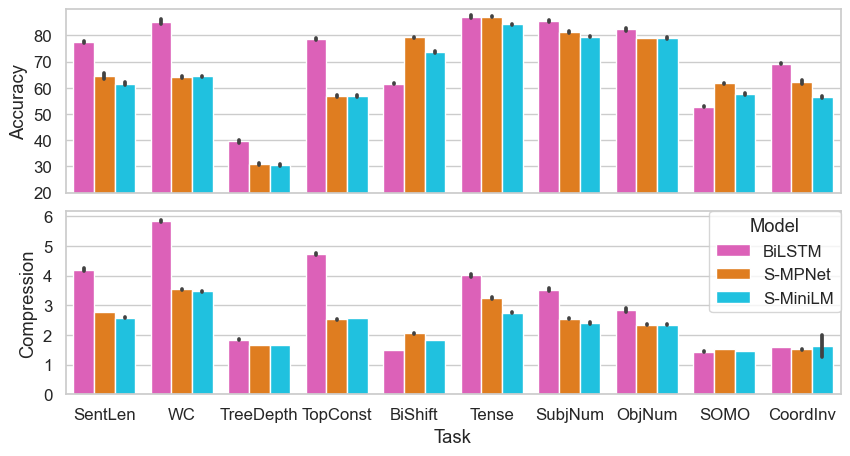

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

# Increase font size
sns.set(font_scale=1.1)

# sns remove background
sns.set_style("whitegrid", {'axes.grid' : False})

task_order = list(task_dict.values())

palette = sns.color_palette("bright")
palette = [palette[6], palette[1], palette[-1]]
fix, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

ax = axes[0]
# Plot accuracy where y-axis is the accuracy, x-axis is task and hue is model
sns.barplot(data=results_classification, x='task', y='accuracy', hue='model',
            width=.8, ax=ax, order=task_order, palette=palette, errorbar="sd")

# Remove legend
ax.legend().remove()

# Remove x label
ax.set_xlabel('')
ax.set_ylabel('Accuracy')
ax.grid(axis='y')

# Make y axis have more ticks from 0-1 with 0.1
ax.set_yticks(np.arange(20, 90, 10))

# Set y limit
ax.set_ylim(20, 90)

ax = axes[1]
# Plot accuracy where y-axis is the accuracy, x-axis is task and hue is model
sns.barplot(data=results_classification, x='task', y='compression_ratio', hue='model',
            width=.8, ax=ax, order=task_order, palette=palette, errorbar="sd")

# Rename y label
ax.set_ylabel('Compression')
ax.set_xlabel('Task')
ax.grid(axis='y')

# y axis ticks
ax.set_yticks(np.arange(0, 7, 1))

# put legend outside the figure
ax.legend(bbox_to_anchor=(1, 1),borderaxespad=0, title='Model')

plt.subplots_adjust(hspace=0.1)

plt.savefig('../plots/classification_results.png', bbox_inches='tight')
plt.savefig('../plots/classification_results.pdf', bbox_inches='tight', format='pdf', dpi=150)
plt.show()


# Model classification with PCA

In [10]:
# Get values only from the last layer of each model
results_classification = results.query("(model == 'bilstm') | (model != 'bilstm' & layer == 12)" ).query("pca == True")

# Rename model names
results_classification['model'] = results_classification['model'].replace({'bilstm': "BiLSTM", 'mpnet': "S-MPNet", 'MiniLM': "S-MiniLM"})

results_classification

,model,task,layer,accuracy,f1,uniform_codelength,online_codelength,compression_ratio,pca
7,BiLSTM,BiShift,0,52.170000,52.050606,100000.000000,69742.146577,1.43,True
31,S-MiniLM,SOMO,12,55.114847,54.978381,83157.000000,57555.592576,1.44,True
36,S-MPNet,SentLen,12,39.261784,39.796635,225946.402263,119745.710732,1.89,True
39,S-MiniLM,TopConst,12,40.926304,39.705390,303334.523340,147943.567018,2.05,True
60,S-MiniLM,SentLen,12,40.625367,40.302454,225946.402263,119428.921708,1.89,True
...,...,...,...,...,...,...,...,...,...
1365,S-MiniLM,CoordInv,12,53.319336,53.241149,100002.000000,69671.230817,1.44,True
1396,S-MPNet,SubjNum,12,77.457357,77.438434,82010.000000,38256.237297,2.14,True
1414,BiLSTM,WC,0,54.575550,52.934111,835568.162176,266649.686198,3.13,True
1433,S-MPNet,TreeDepth,12,23.709902,23.940470,239579.669048,156376.047186,1.53,True


In [11]:
table = results_classification.pivot_table(index='task', columns='model', values='accuracy', aggfunc='mean').round(1)

# Sort rows by task order
task_order = list(task_dict.values())
table.reindex(task_order)

model,BiLSTM,S-MPNet,S-MiniLM
task,,,
SentLen,71.3,39.7,40.1
WC,54.4,53.6,53.5
TreeDepth,33.5,23.8,24.4
TopConst,63.9,36.7,40.9
BiShift,51.7,64.5,62.9
Tense,86.6,86.3,82.0
SubjNum,79.9,77.3,76.2
ObjNum,76.6,72.8,74.3
SOMO,54.7,56.9,55.1


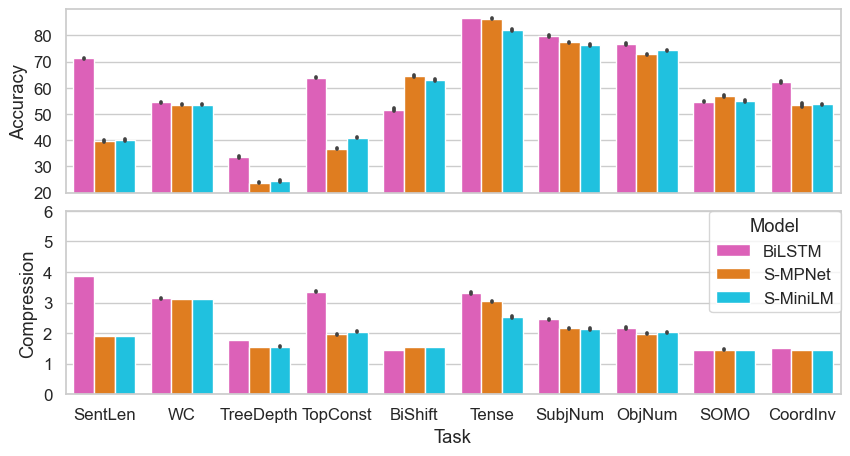

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

# Increase font size
sns.set(font_scale=1.1)

# sns remove background
sns.set_style("whitegrid", {'axes.grid' : False})

task_order = list(task_dict.values())
hue_order=['BiLSTM', 'S-MPNet', 'S-MiniLM']

palette = sns.color_palette("bright")
palette = [palette[6], palette[1], palette[-1]]
fix, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)


ax = axes[0]
# Plot accuracy where y-axis is the accuracy, x-axis is task and hue is model
sns.barplot(data=results_classification, x='task', y='accuracy', hue='model',
            hue_order=hue_order, width=.8, ax=ax, order=task_order,
            palette=palette, errorbar="sd")

# Remove legend
ax.legend().remove()

# Remove x label
ax.set_xlabel('')
ax.set_ylabel('Accuracy')
ax.grid(axis='y')

# Make y axis have more ticks from 0-1 with 0.1
ax.set_yticks(np.arange(20, 90, 10))

# Set y limit
ax.set_ylim(20, 90)

ax = axes[1]
# Plot accuracy where y-axis is the accuracy, x-axis is task and hue is model
sns.barplot(data=results_classification, x='task', y='compression_ratio', hue='model',
            hue_order=hue_order, width=.8, ax=ax, order=task_order,
            palette=palette, errorbar="sd")

# Rename y label
ax.set_ylabel('Compression')
ax.set_xlabel('Task')
ax.grid(axis='y')

# y axis ticks
ax.set_yticks(np.arange(0, 7, 1))

# put legend outside the figure
ax.legend(bbox_to_anchor=(1, 1),borderaxespad=0, title='Model')

plt.subplots_adjust(hspace=0.1)

plt.savefig('../plots/classification_results-pca.png', bbox_inches='tight')
plt.savefig('../plots/classification_results-pca.pdf', bbox_inches='tight', format='pdf', dpi=150)
plt.show()


## Layer results

/tmp/ipykernel_554048/698393037.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_classification['model'] = results_classification['model'].replace({'mpnet': "S-MPNet", 'MiniLM': "S-MiniLM"})


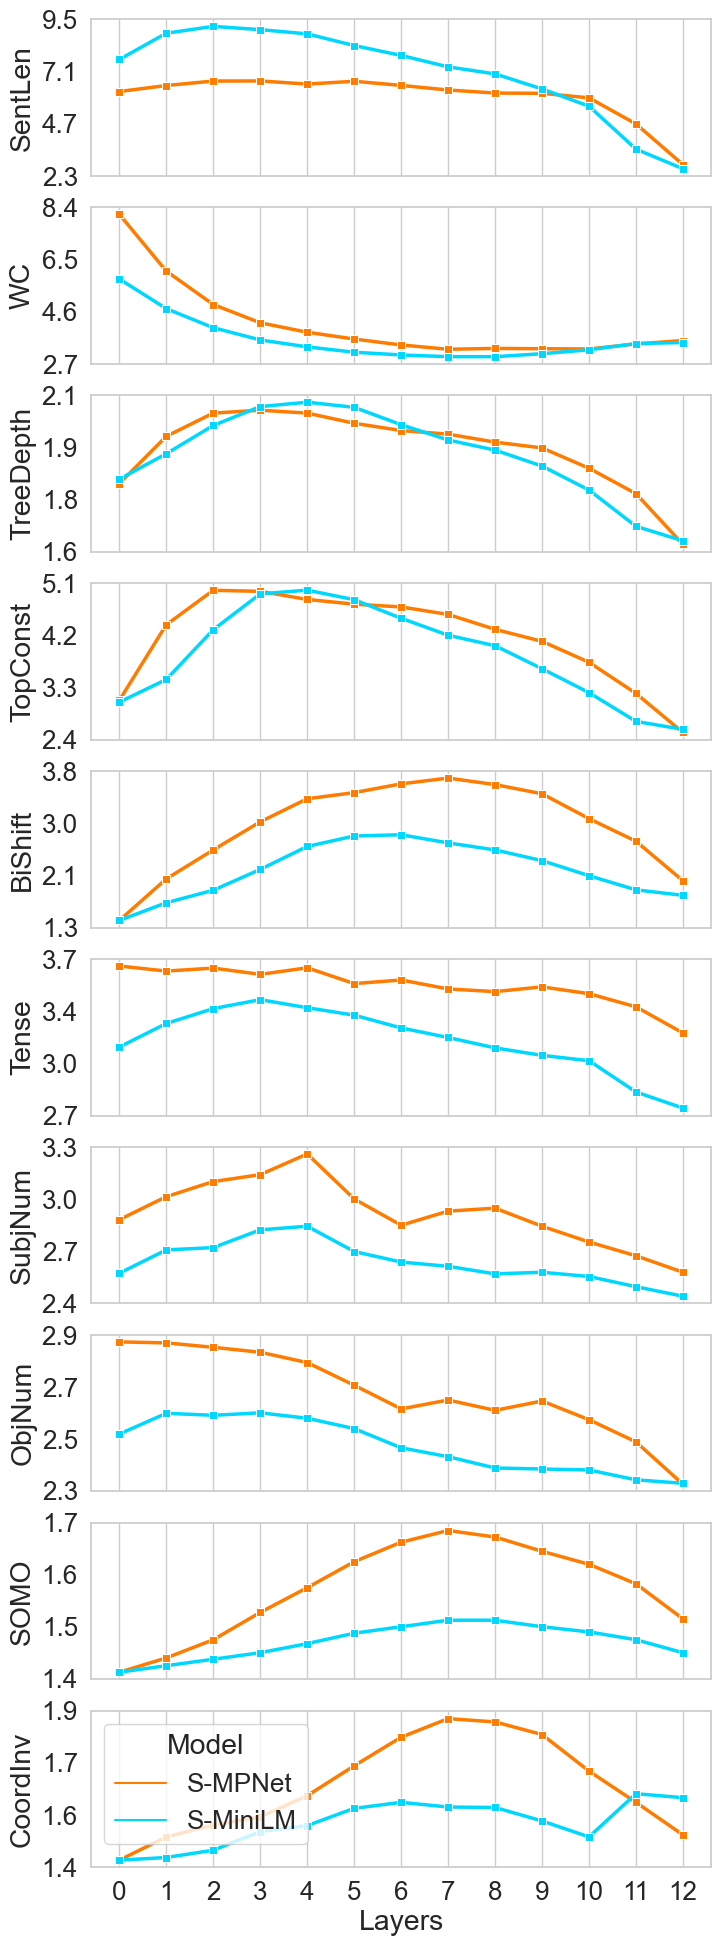

In [9]:
sns.set(font_scale=1.7)
sns.set_style("whitegrid", {'axes.grid' : False})

fix, axes = plt.subplots(10, 1, figsize=(8,24), sharex=True)

palette = sns.color_palette("bright")
palette = [palette[1], palette[-1]]

results_classification = results.query("(model != 'bilstm')")
results_classification['model'] = results_classification['model'].replace({'mpnet': "S-MPNet", 'MiniLM': "S-MiniLM"})


for i, task in enumerate(task_order):
    subset = results_classification.query(f"task == '{task}'")

    ax = axes[i]

    sns.lineplot(data=subset, x='layer', y='compression_ratio', hue='model', hue_order=['S-MPNet', 'S-MiniLM'], ax=ax, palette=palette, marker='s', errorbar=None, linewidth=2.5)

    ax.grid(axis='x')

    ax.set_xticks(np.arange(0, 13, 1)) # Set x axis ticks
    ax.set_yticks(np.linspace(np.round(ax.get_ybound()[0], 2), np.round(ax.get_ybound()[1], 2), 4))
    ax.set_ylabel(task) # Rename y label
    ax.set_xlabel('Layers')

    # Get the current locations and labels
    locs, labels = ax.get_yticks(), ax.get_yticklabels()

    # Set new labels to the current locations
    new_labels = ['{:0.1f}'.format(loc) for loc in locs]
    ax.set_yticklabels(new_labels)

    # If not last plot, remove legend
    if i != len(task_order) - 1:
        ax.get_legend().remove()
    else:
        ax.legend(title='Model')

plt.subplots_adjust(hspace=0.2)

plt.savefig('plots/results/layer_compression.png', bbox_inches='tight')
plt.savefig('plots/results/layer_compression.pdf', bbox_inches='tight', format='pdf', dpi=200)

plt.show()

## Best model
Analyze the results and get the best model per layer

In [ ]:
# Per model and task, get the best layer based on compression ratio and filter out the rest
t = results.sort_values(by=['model', 'task', 'compression_ratio'], ascending=False)

# Get the best layer for each model and task
r = t.groupby(['model', 'task']).head(1).sort_values(by=['task', 'compression_ratio'], ascending=False)
r.query('task == "Tense"')

,model,task,layer,accuracy,f1,uniform_codelength,online_codelength,compression_ratio,pca
853,bilstm,Tense,0,87.364413,87.359605,85700.0,21223.011211,4.04,False
1180,mpnet,Tense,4,88.276021,88.273697,85700.0,22657.939262,3.78,False
1373,MiniLM,Tense,3,87.618278,87.617914,85700.0,24171.234590,3.55,False


Now get the best and worst model pert task independent of the layer

In [ ]:
models = ['mpnet', 'MiniLM', 'bilstm']
best, worst = {model: 0 for model in models}, {model: 0 for model in models}

for task in task_dict.values():
    best_model = r.query(f'task == "{task}"').iloc[0]['model']
    worst_model = r.query(f'task == "{task}"').iloc[-1]['model']
    best[best_model] += 1
    worst[worst_model] += 1

print(best, worst)

{'mpnet': 4, 'MiniLM': 4, 'bilstm': 2} {'mpnet': 0, 'MiniLM': 4, 'bilstm': 6}
